# Comparing the geometric similarity of trajectories

Here we compare the geometric similarity of trajectories using the following path metrics:

 - the Hausdorff distance
 - the discrete Fréchet

**Last executed:** May 18, 2021 with MDAnalysis 1.1.1

**Last updated:** January 2020

**Minimum version of MDAnalysis:** 0.18.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests
   
**Optional packages for visualisation:**

* [matplotlib](https://matplotlib.org)
* [seaborn](https://seaborn.pydata.org)


<div class="alert alert-info">
    
**Note**

The metrics and methods in the `psa` path similarity analysis module are from (<a data-cite="seyler_path_2015" href="https://doi.org/10.1371/journal.pcbi.1004568">Seyler *et al.*, 2015</a>). Please cite them when using the ``MDAnalysis.analysis.psa`` module in published work.

</div>

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import (PSF, DCD, DCD2, GRO, XTC, 
                                        PSF_NAMD_GBIS, DCD_NAMD_GBIS,
                                        PDB_small, CRD)
from MDAnalysis.analysis import psa

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>) 

In [2]:
u1 = mda.Universe(PSF, DCD)
u2 = mda.Universe(PSF, DCD2)
u3 = mda.Universe(GRO, XTC)
u4 = mda.Universe(PSF_NAMD_GBIS, DCD_NAMD_GBIS)
u5 = mda.Universe(PDB_small, CRD, PDB_small, 
                  CRD, PDB_small, CRD, PDB_small)

ref = mda.Universe(PDB_small)


labels = ['DCD', 'DCD2', 'XTC', 'NAMD', 'mixed']

The trajectories can have different lengths, as seen below.

In [3]:
print(len(u1.trajectory), len(u2.trajectory), len(u3.trajectory))

98 102 10


## Aligning trajectories

We set up the PSAnalysis ([API docs](https://docs.mdanalysis.org/stable/documentation_pages/analysis/psa.html#MDAnalysis.analysis.psa.PSAnalysis)) with our list of Universes and labels. While `path_select` determines which atoms to calculate the path similarities for, `select` determines which atoms to use to align each Universe to `reference`.

In [4]:
CORE_sel = 'name CA and (resid 1:29 or resid 60:121 or resid 160:214)'

ps = psa.PSAnalysis([u1, u2, u3, u4, u5],
                    labels=labels,
                    reference=ref,
                    select=CORE_sel,
                    path_select='name CA')

## Generating paths

For each Universe, we will generate a transition path containing each conformation from a trajectory using `generate_paths` ([API docs](https://docs.mdanalysis.org/stable/documentation_pages/analysis/psa.html#MDAnalysis.analysis.psa.PSAnalysis.generate_paths)).


First, we will do a mass-weighted alignment of each trajectory to the reference structure `reference`, along the atoms in `select`. To turn off the mass weighting, set `weights=None`. If your trajectories are already aligned, you can skip the alignment with `align=False`.

In [5]:
ps.generate_paths(align=True, save=False, weights='mass')

## Hausdorff method

Now we can compute the similarity of each path. The default metric is to use the Hausdorff method. [[5]](#References) The Hausdorff distance between two conformation transition paths $P$ and $Q$ is:

$$\delta_H(P,Q) = \max{(\delta_h(P|Q), \delta_h(Q|P))}$$

$\delta_h(P|Q)$ is the directed Hausdorff distance from $P$ to $Q$, and is defined as:

$$\delta_h(P|Q) = \max_{p \in P}\min_{q \in Q} d(p,q)$$

The directed Hausdorff distance of $P$ to $Q$ is the distance between the two points, $p \in P$ and its structural nearest neighbour $q \in Q$, for the point $p$ where the distance is greatest. This is not commutative, i.e. the directed Hausdorff distance from $Q$ to $P$ is not the same. (See [scipy.spatial.distance.directed_hausdorff](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html) for more information).

In MDAnalysis, the Hausdorff distance is the RMSD between a pair of conformations in $P$ and $Q$, where the one of the conformations in the pair has the least similar nearest neighbour.

In [6]:
ps.run(metric='hausdorff')

The distance matrix is saved in `ps.D`.

In [7]:
ps.D

array([[ 0.        ,  1.33312648, 22.37206002,  2.04737477,  7.55204678],
       [ 1.33312648,  0.        , 22.3991666 ,  2.07957562,  7.55032598],
       [22.37206002, 22.3991666 ,  0.        , 22.42282661, 25.74534554],
       [ 2.04737477,  2.07957562, 22.42282661,  0.        ,  7.67052252],
       [ 7.55204678,  7.55032598, 25.74534554,  7.67052252,  0.        ]])

### Plotting

`psa.PSAnalysis` provides two convenience methods for plotting this data. The first is to plot a heat-map dendrogram from clustering the trajectories based on their path similarity. You can use any clustering method supported by [scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html); the default is 'ward'.

(array([[ 0.        ,  1.        ,  1.33312648,  2.        ],
        [ 3.        ,  5.        ,  2.25503365,  3.        ],
        [ 4.        ,  6.        ,  9.20452463,  4.        ],
        [ 2.        ,  7.        , 29.13448037,  5.        ]]),
 {'icoord': [[35.0, 35.0, 45.0, 45.0],
   [25.0, 25.0, 40.0, 40.0],
   [15.0, 15.0, 32.5, 32.5],
   [5.0, 5.0, 23.75, 23.75]],
  'dcoord': [[0.0, 1.3331264831939273, 1.3331264831939273, 0.0],
   [0.0, 2.2550336453918844, 2.2550336453918844, 1.3331264831939273],
   [0.0, 9.204524628710315, 9.204524628710315, 2.2550336453918844],
   [0.0, 29.134480368642226, 29.134480368642226, 9.204524628710315]],
  'ivl': ['2', '4', '3', '0', '1'],
  'leaves': [2, 4, 3, 0, 1],
  'color_list': ['C1', 'C1', 'C0', 'C0'],
  'leaves_color_list': ['C0', 'C0', 'C1', 'C1', 'C1']},
 array([[ 0.        , 25.74534554, 22.42282661, 22.37206002, 22.3991666 ],
        [25.74534554,  0.        ,  7.67052252,  7.55204678,  7.55032598],
        [22.42282661,  7.67052252,  0

<Figure size 432x288 with 0 Axes>

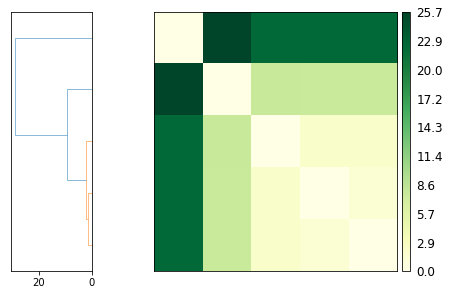

In [8]:
ps.plot(linkage='ward')

The other is to plot a heatmap annotated with the distance values. Again, the trajectories are displayed in an arrangement that fits the clustering method.

<div class="alert alert-info">
    
**Note**

You will need to install the data visualisation library [Seaborn](https://seaborn.pydata.org/installing.html) for this function.

</div>

(array([[ 0.        ,  1.        ,  1.33312648,  2.        ],
        [ 3.        ,  5.        ,  2.04737477,  3.        ],
        [ 4.        ,  6.        ,  7.55032598,  4.        ],
        [ 2.        ,  7.        , 22.37206002,  5.        ]]),
 {'icoord': [[35.0, 35.0, 45.0, 45.0],
   [25.0, 25.0, 40.0, 40.0],
   [15.0, 15.0, 32.5, 32.5],
   [5.0, 5.0, 23.75, 23.75]],
  'dcoord': [[0.0, 1.3331264831939273, 1.3331264831939273, 0.0],
   [0.0, 2.047374774767044, 2.047374774767044, 1.3331264831939273],
   [0.0, 7.550325981004795, 7.550325981004795, 2.047374774767044],
   [0.0, 22.372060021101248, 22.372060021101248, 7.550325981004795]],
  'ivl': ['2', '4', '3', '0', '1'],
  'leaves': [2, 4, 3, 0, 1],
  'color_list': ['C1', 'C1', 'C0', 'C0'],
  'leaves_color_list': ['C0', 'C0', 'C1', 'C1', 'C1']},
 array([[ 0.        , 25.74534554, 22.42282661, 22.37206002, 22.3991666 ],
        [25.74534554,  0.        ,  7.67052252,  7.55204678,  7.55032598],
        [22.42282661,  7.67052252,  0.  

<Figure size 432x288 with 0 Axes>

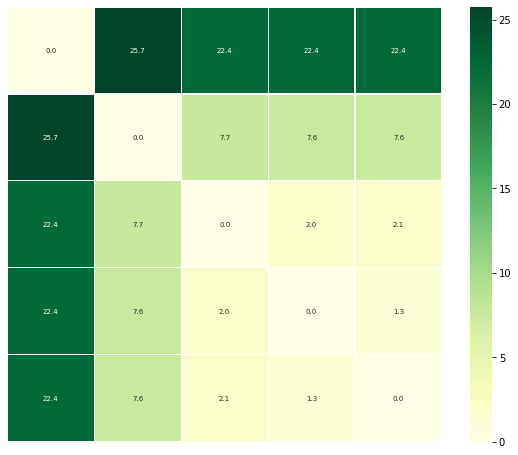

In [9]:
ps.plot_annotated_heatmap(linkage='single')

## Discrete Fréchet distances

The discrete Fréchet distance between two conformation transition paths $P$ and $Q$ is:

$$\delta_{dF}(P,Q) = \min_{C \in \Gamma_{P,Q}} \|C\|$$

where $C$ is  a coupling in the set of all couplings $\Gamma_{P,Q}$ between $P$ and $Q$. A coupling $C(P,Q)$ is a sequence of pairs of conformations in $P$ and $Q$, where the first/last pairs are the first/last points of the respective paths, and for each successive pair, at least one point in $P$ or $Q$ must advance to the next frame.

$$ C(P,Q) \equiv  (p_{a_1}, q_{b_1}), (p_{a_2}, q_{b_2}), ..., (p_{a_L}, q_{b_L}) $$

The coupling distance $\|C\|$ is the largest distance between a pair of points in such a sequence.

$$\|C\| \equiv \max_{i=1, ..., L} d(p_{a_i}, q_{b_i})$$


In MDAnalysis, the discrete Fréchet distance is the lowest possible RMSD between a conformation from $P$ and a conformation from $Q$, where the two frames are at similar points along the trajectory, and they are the least structurally similar in that particular coupling sequence. [[6-9]](#References)

In [10]:
ps.run(metric='discrete_frechet')
ps.D

array([[ 0.        ,  1.33312649, 22.37205967,  2.04737475,  7.55204694],
       [ 1.33312649,  0.        , 22.39916723,  2.07957565,  7.55032613],
       [22.37205967, 22.39916723,  0.        , 22.42282569, 25.74534511],
       [ 2.04737475,  2.07957565, 22.42282569,  0.        ,  7.67052241],
       [ 7.55204694,  7.55032613, 25.74534511,  7.67052241,  0.        ]])

### Plotting

(array([[ 0.        ,  1.        ,  1.33312649,  2.        ],
        [ 3.        ,  5.        ,  2.25503365,  3.        ],
        [ 4.        ,  6.        ,  9.20452471,  4.        ],
        [ 2.        ,  7.        , 29.13448001,  5.        ]]),
 {'icoord': [[35.0, 35.0, 45.0, 45.0],
   [25.0, 25.0, 40.0, 40.0],
   [15.0, 15.0, 32.5, 32.5],
   [5.0, 5.0, 23.75, 23.75]],
  'dcoord': [[0.0, 1.3331264917717554, 1.3331264917717554, 0.0],
   [0.0, 2.2550336465704057, 2.2550336465704057, 1.3331264917717554],
   [0.0, 9.204524708552725, 9.204524708552725, 2.2550336465704057],
   [0.0, 29.134480014437507, 29.134480014437507, 9.204524708552725]],
  'ivl': ['2', '4', '3', '0', '1'],
  'leaves': [2, 4, 3, 0, 1],
  'color_list': ['C1', 'C1', 'C0', 'C0'],
  'leaves_color_list': ['C0', 'C0', 'C1', 'C1', 'C1']},
 array([[ 0.        , 25.74534511, 22.42282569, 22.37205967, 22.39916723],
        [25.74534511,  0.        ,  7.67052241,  7.55204694,  7.55032613],
        [22.42282569,  7.67052241,  0

<Figure size 432x288 with 0 Axes>

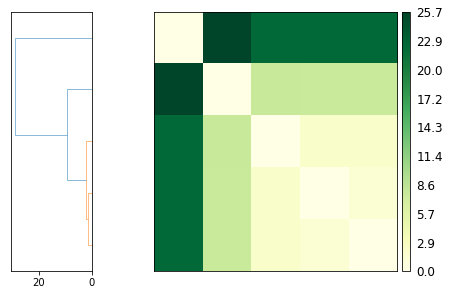

In [11]:
ps.plot(linkage='ward')

(array([[ 0.        ,  1.        ,  1.33312649,  2.        ],
        [ 3.        ,  5.        ,  2.04737475,  3.        ],
        [ 4.        ,  6.        ,  7.55032613,  4.        ],
        [ 2.        ,  7.        , 22.37205967,  5.        ]]),
 {'icoord': [[35.0, 35.0, 45.0, 45.0],
   [25.0, 25.0, 40.0, 40.0],
   [15.0, 15.0, 32.5, 32.5],
   [5.0, 5.0, 23.75, 23.75]],
  'dcoord': [[0.0, 1.3331264917717554, 1.3331264917717554, 0.0],
   [0.0, 2.047374750604888, 2.047374750604888, 1.3331264917717554],
   [0.0, 7.550326126269361, 7.550326126269361, 2.047374750604888],
   [0.0, 22.37205966687729, 22.37205966687729, 7.550326126269361]],
  'ivl': ['2', '4', '3', '0', '1'],
  'leaves': [2, 4, 3, 0, 1],
  'color_list': ['C1', 'C1', 'C0', 'C0'],
  'leaves_color_list': ['C0', 'C0', 'C1', 'C1', 'C1']},
 array([[ 0.        , 25.74534511, 22.42282569, 22.37205967, 22.39916723],
        [25.74534511,  0.        ,  7.67052241,  7.55204694,  7.55032613],
        [22.42282569,  7.67052241,  0.    

<Figure size 432x288 with 0 Axes>

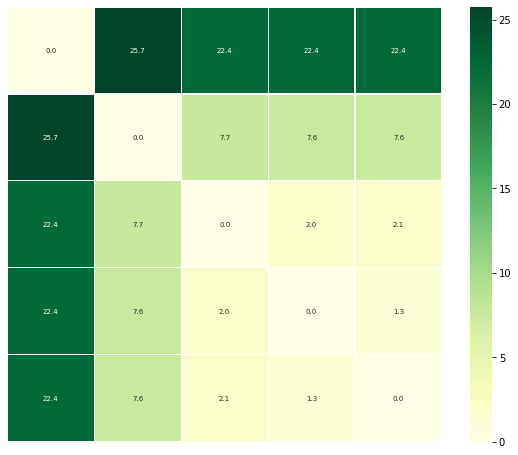

In [12]:
ps.plot_annotated_heatmap(linkage='single')

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[4] Sean&nbsp;L. Seyler, Avishek Kumar, M.&nbsp;F. Thorpe, and Oliver Beckstein.
Path <span class="bibtex-protected">Similarity</span> <span class="bibtex-protected">Analysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Method</span> for <span class="bibtex-protected">Quantifying</span> <span class="bibtex-protected">Macromolecular</span> <span class="bibtex-protected">Pathways</span>.
<em>PLOS Computational Biology</em>, 11(10):e1004568, October 2015.
URL: <a href="https://dx.plos.org/10.1371/journal.pcbi.1004568">https://dx.plos.org/10.1371/journal.pcbi.1004568</a>, <a href="https://doi.org/10.1371/journal.pcbi.1004568">doi:10.1371/journal.pcbi.1004568</a>.